In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import lazyqsar as lq
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
current_directory = os.path.dirname(__file__)
filename = os.path.join(current_directory, "..", "Data", "My_data", "Final_processed.csv")
df = pd.read_csv(filename)
df

In [5]:
SMILES = "SMILES"
EXP = "Active"

In [ ]:
import matplotlib.pyplot as plt
x = df[EXP]
print(x)

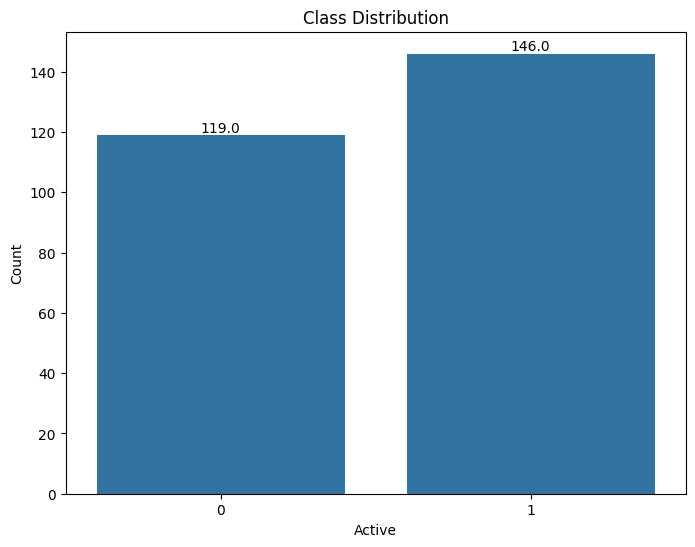

1    146
0    119
Name: Active, dtype: int64


In [5]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=x, data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xlabel('Active')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

activity_counts = df['Active'].value_counts()
print(activity_counts)

In [6]:
# Assuming SMILES and EXP are defined earlier in your code
SMILES = 'SMILES'
EXP = 'Active'

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df[SMILES], df[EXP], indices, test_size=size, stratify=df[EXP])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

In [7]:
train, test = random_split(df, 0.2)
train.to_csv("train_set.csv", index=False)
test.to_csv("test_set.csv", index=False)

In [10]:
smiles = train[SMILES]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

# Filter out None molecules
valid_mols = [mol for mol in mols if mol is not None]

# Specify the radius and number of bits for Morgan fingerprint
radius = 3
nBits = 2048

In [ ]:
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.MorganBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]

-------- MorganBinaryClassifier_600 Classification Report --------
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.78      0.82      0.80        22

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44

-------- MorganBinaryClassifier_600 Confusion Matrix --------


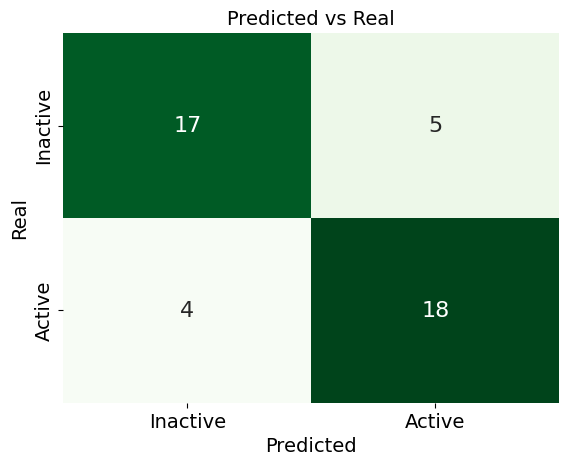

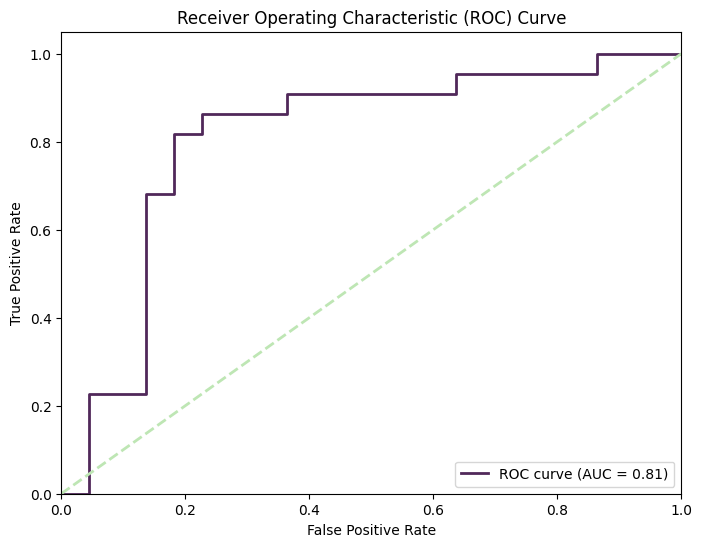

In [26]:
model_name = 'MorganBinaryClassifier_600'
test = test.dropna(subset=[SMILES])
test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_test = test[SMILES]
y = model.predict_proba(smiles_test)
y_pred = model.predict(smiles_test)

# Classification Report
print(f"-------- {model_name} Classification Report --------")
y_test = test[EXP]
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

#Plotting ROC-AUC curve
from sklearn.metrics import roc_curve, auc
# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
model.save("model_morgan600.joblib")

In [ ]:
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]

-------- MorganBinaryClassifier_60 Classification Report --------
              precision    recall  f1-score   support

           0       0.94      0.73      0.82        22
           1       0.78      0.95      0.86        22

    accuracy                           0.84        44
   macro avg       0.86      0.84      0.84        44
weighted avg       0.86      0.84      0.84        44

-------- MorganBinaryClassifier_60 Confusion Matrix --------


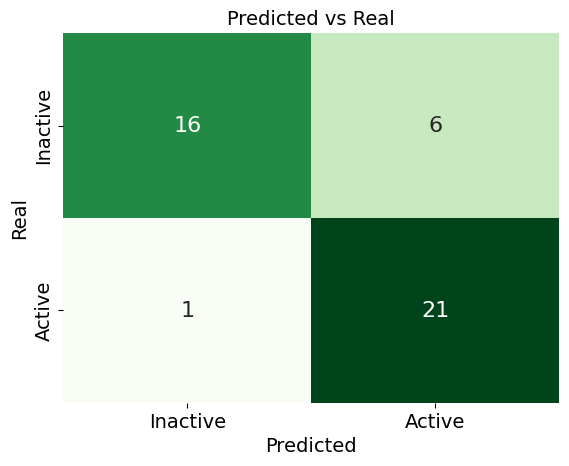

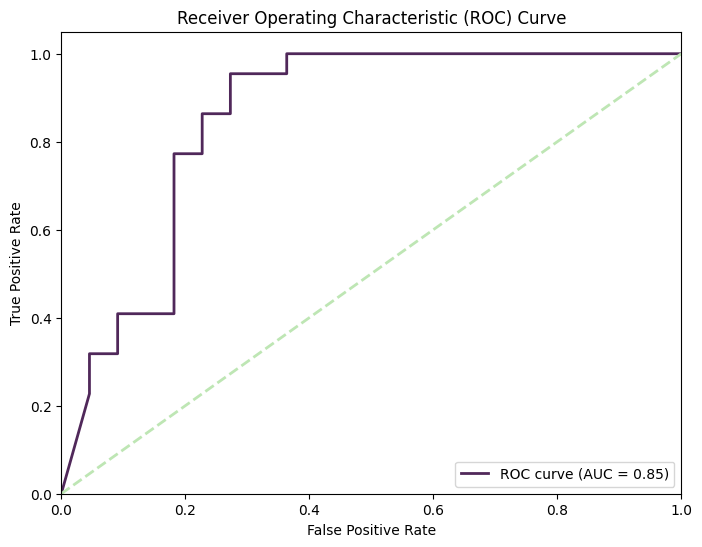

In [9]:
model_name = 'MorganBinaryClassifier_60'
test = test.dropna(subset=[SMILES])
test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_test = test[SMILES]
y = model.predict_proba(smiles_test)
y_pred = model.predict(smiles_test)

# Classification Report
print(f"-------- {model_name} Classification Report --------")
y_test = test[EXP]
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

#Plotting ROC-AUC curve
from sklearn.metrics import roc_curve, auc
# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
model.save("model_morgan60.joblib")

In [ ]:
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]

-------- ErsiliaBinaryClassifier_60 Classification Report --------
              precision    recall  f1-score   support

           0       0.74      0.64      0.68        22
           1       0.68      0.77      0.72        22

    accuracy                           0.70        44
   macro avg       0.71      0.70      0.70        44
weighted avg       0.71      0.70      0.70        44

-------- ErsiliaBinaryClassifier_60 Confusion Matrix --------


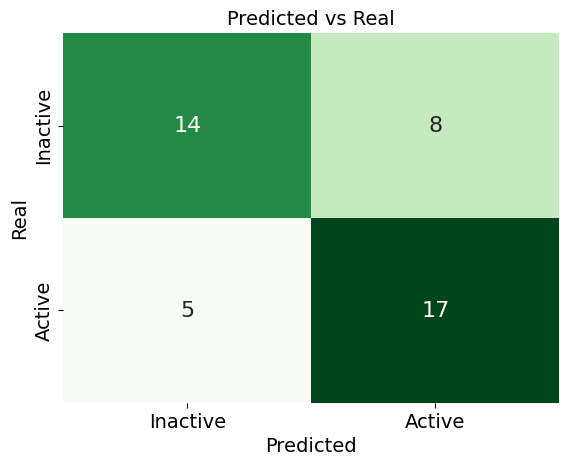

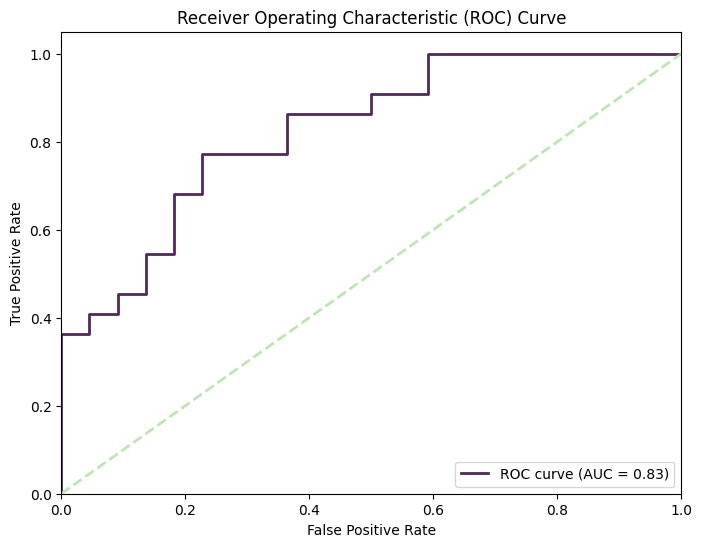

In [12]:
model_name = 'ErsiliaBinaryClassifier_60'
test = test.dropna(subset=[SMILES])
test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_test = test[SMILES]
y = model.predict_proba(smiles_test)
y_pred = model.predict(smiles_test)

# Classification Report
print(f"-------- {model_name} Classification Report --------")
y_test = test[EXP]
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

#Plotting ROC-AUC curve
from sklearn.metrics import roc_curve, auc
# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
model.save("model_eosce60.joblib")

In [ ]:
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]

-------- ErsiliaBinaryClassifier_600 Classification Report --------
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        22
           1       0.75      0.82      0.78        22

    accuracy                           0.77        44
   macro avg       0.78      0.77      0.77        44
weighted avg       0.78      0.77      0.77        44

-------- ErsiliaBinaryClassifier_600 Confusion Matrix --------


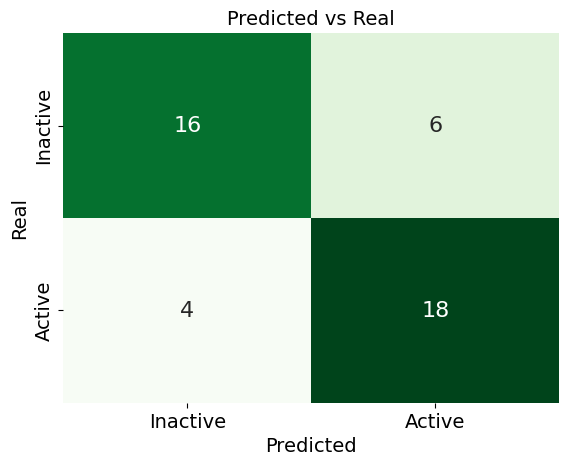

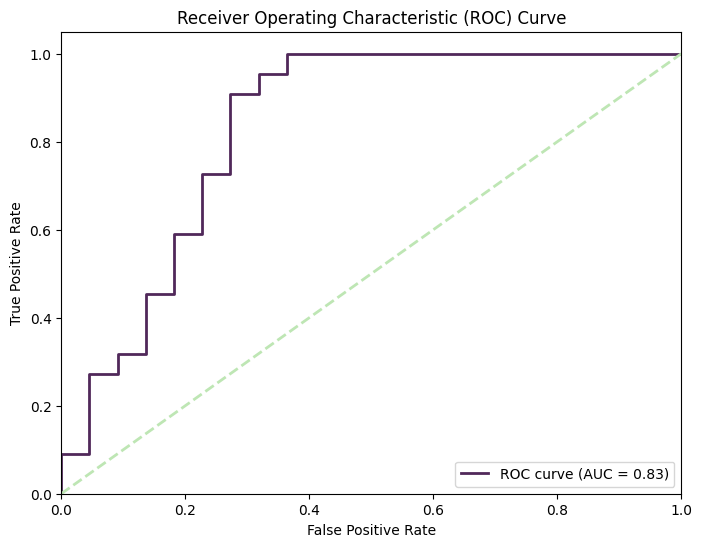

In [17]:
model_name = 'ErsiliaBinaryClassifier_600'
test = test.dropna(subset=[SMILES])
test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_test = test[SMILES]
y = model.predict_proba(smiles_test)
y_pred = model.predict(smiles_test)

# Classification Report
print(f"-------- {model_name} Classification Report --------")
y_test = test[EXP]
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"-------- {model_name} Confusion Matrix --------")
conf_mat =  confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

#Plotting ROC-AUC curve
from sklearn.metrics import roc_curve, auc
# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
model.save("model_eosce600.joblib")